# Toy example, compare MLP and Ensemble NC

## Generate Data

Couldn't import dot_parser, loading of dot files will not be possible.


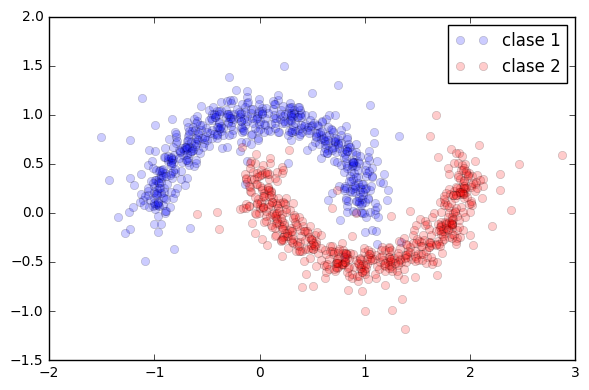

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm, cross_validation, cluster, datasets
from theano import config

data_noise = [(1000, 0.1), (100, 0.3), (25, 0.5)]

X = []
y = []

for n_samples, noise in data_noise:
    X0, y0 = datasets.make_moons(n_samples=n_samples, noise=noise)
    X.append(X0)
    y.append(y0)

X = np.concatenate(X)
y = np.concatenate(y)

x1_samples = X[y==0, :]
x2_samples = X[y==1, :]

plt.plot(x1_samples[:, 0], x1_samples[:, 1], 'bo', alpha=0.2)
plt.plot(x2_samples[:, 0], x2_samples[:, 1], 'ro', alpha=0.2)

classes_names = [0, 1]
labels = ['clase 1', 'clase 2']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4,
                                                                     random_state=13, stratify=y)

X_train = np.array(X_train, dtype=config.floatX)
X_test = np.array(X_test, dtype=config.floatX)
y_train = np.array(y_train, dtype=config.floatX)
y_test = np.array(y_test, dtype=config.floatX)

plt.legend(labels)
plt.tight_layout()

## Training MLP

In [9]:
import os
import sys

sys.path.insert(0, os.path.abspath('../..'))

from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import *
from deepensemble.metrics import *
import theano.tensor as T

# create MLP
mlp = Sequential("mlp", "classifier", classes_names)
mlp.add_layer(Dense(n_input=X.shape[1], n_output=18, activation=T.tanh))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
mlp.append_cost(mse, name='MSE')
mlp.set_update(sgd, name='SGD', learning_rate=0.01)
mlp.compile(fast=True)

max_epoch = 500  # max epoch training

metrics_mlp = FactoryMetrics.get_metric(mlp)

metric = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, early_stop=False)

metrics_mlp.append_prediction(X_test, y_test)
metrics_mlp.append_metric(metric)

metrics_mlp.classification_report()

Start Compile mlp  - elapsed: 1.51 [s]
mlp - fold: 6, epoch:[####################] 500/500 elapsed: 2.48[s] - left: 0.00[s] | error: 0.0098, score: 0.9902 / 0.9922
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          99.55 +-0.00      98.22 +-0.00      98.88 +-0.00      225               
1          98.25 +-0.00      99.56 +-0.00      98.90 +-0.00      225               
----------------------------------------------------------------------------
average:   98.90 +-0.00      98.89 +-0.00      98.89 +-0.00      
----------------------------------------------------------------------------



## Training Ensemble

In [8]:
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *

# create ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(3):
    net = Sequential("net%d_ens" % i, "classifier", classes_names)
    net.add_layer(Dense(n_input=X.shape[1], n_output=6, activation=T.tanh))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
    net.append_cost(kullback_leibler_generalized, name='KLG')
    net.set_update(sgd, name='SGD', learning_rate=0.01)
    ensemble.append_model(net)

ensemble.add_cost_ensemble(fun_cost=neg_correntropy, name='NEG_CORRPY', lamb=10)
ensemble.set_combiner(PluralityVotingCombiner())
ensemble.compile(fast=True)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

metric = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, early_stop=False)

metrics_ensemble.append_prediction(X_test, y_test)
metrics_ensemble.append_metric(metric)

metrics_ensemble.classification_report()

Start Compile Ensemble  - elapsed: 4.50 [s]
Ensemble - fold: 5, epoch:[####################] 500/500 elapsed: 5.67[s] - left: 0.00[s] | error: 0.0117, score: 0.9883 / 0.9922
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          99.10 +-0.00      98.22 +-0.00      98.66 +-0.00      225               
1          98.24 +-0.00      99.11 +-0.00      98.67 +-0.00      225               
----------------------------------------------------------------------------
average:   98.67 +-0.00      98.67 +-0.00      98.67 +-0.00      
----------------------------------------------------------------------------



## Plot MLP vs Ensemble

## Plot Models Ensemble

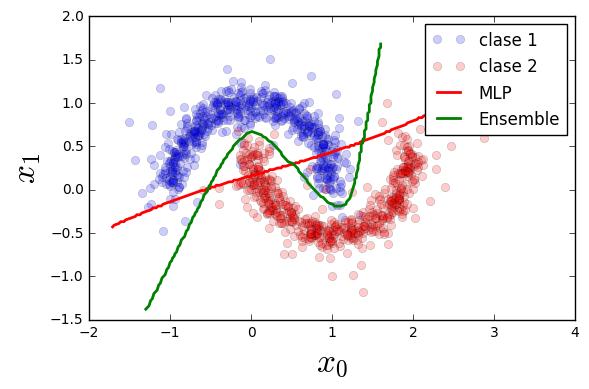

In [4]:
import matplotlib._cntr as cntr

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x = np.array(np.c_[xx.ravel(), yy.ravel()], dtype=config.floatX)
Z1 = mlp.predict(x)
Z2 = ensemble.predict(x)

# Put the result into a color plot
z1 = Z1.reshape(xx.shape)
z2 = Z2.reshape(xx.shape)

def get_contour(x, y, z):
    c = cntr.Cntr(x, y, z)
    level = 0.5
    nlist = c.trace(level, level, 0)
    segs = nlist[:len(nlist)//2]
    x1 = []
    y1 = []
    for seg in segs:
        x1 = np.concatenate((x1, seg[:,0]))
        y1 = np.concatenate((y1, seg[:,1]))
    return x1, y1


xx1, yy1 = get_contour(xx, yy, z1)
xx2, yy2 = get_contour(xx, yy, z2)

n_sep = 2

fig = plt.figure()
plt.plot(x1_samples[:,0],x1_samples[:,1], 'bo', alpha=0.2)
plt.plot(x2_samples[:,0],x2_samples[:,1], 'ro', alpha=0.2)
plt.plot(xx1[0::n_sep], yy1[0::n_sep], '-r', linewidth=2)
plt.plot(xx2[0::n_sep], yy2[0::n_sep], '-g', linewidth=2)
plt.legend(labels + ['MLP', 'Ensemble'])
plt.xlabel('$x_0$', fontsize=24)
plt.ylabel('$x_1$', fontsize=24)
plt.tight_layout()

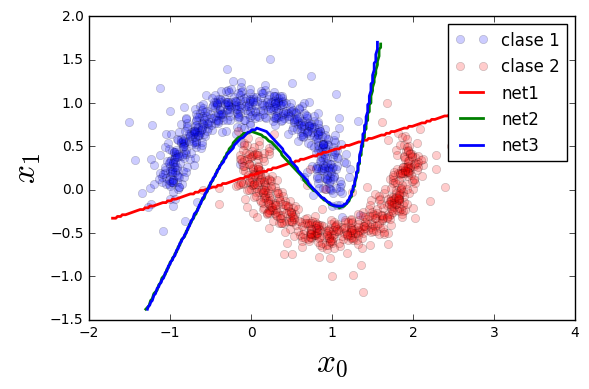

In [5]:

Z21 = ensemble.get_models()[0].predict(x)
Z22 = ensemble.get_models()[1].predict(x)
Z23 = ensemble.get_models()[2].predict(x)

# Put the result into a color plot
z21 = Z21.reshape(xx.shape)
z22 = Z22.reshape(xx.shape)
z23 = Z23.reshape(xx.shape)

xx21, yy21 = get_contour(xx, yy, z21)
xx22, yy22 = get_contour(xx, yy, z22)
xx23, yy23 = get_contour(xx, yy, z23)

fig = plt.figure()
plt.plot(x1_samples[:,0],x1_samples[:,1], 'bo', alpha=0.2)
plt.plot(x2_samples[:,0],x2_samples[:,1], 'ro', alpha=0.2)
plt.plot(xx21[0::n_sep], yy21[0::n_sep], '-r', linewidth=2)
plt.plot(xx22[0::n_sep], yy22[0::n_sep], '-g', linewidth=2)
plt.plot(xx23[0::n_sep], yy23[0::n_sep], '-b', linewidth=2)
plt.legend(labels + ['net1', 'net2', 'net3'])
plt.xlabel('$x_0$', fontsize=24)
plt.ylabel('$x_1$', fontsize=24)
plt.tight_layout()